# Data Collection and Analysis of Movie Data
### Authors: Jan Hanzal, Eric Zila

In the first place, necessary imports are made.

Packages:
* package `copy` used for safe data manipulation
* package `matplotlib.pyplot` used for plotting
* package `pandas` used for data frame manipulation
* package `re` used for operations with regular expressions
* package `requests` used for communication with HTTP servers

Classes:
* class `BeautifulSoup` from package `bs4` used for scraping

In [1]:
import copy
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests

from bs4 import BeautifulSoup

When downloading data about movies from IMDb, it is necessary to have an object at hand that is capable of storing these pieces of information in an organized manner. To do so, we have decided to create a separate class called `Movie` that accepts downloaded data pieces as parameters and stores them as instance variables.

In [2]:
"""
Encapsulates information about a movie.
"""
class Movie:
    """
    Initiates Movie class.
    
    @param title -> title of the movie
    @param original_title -> original title of the movie
    @param worldwide_gross -> worldwide gross of the movie
    @param rating -> rating of the movie
    @param rating_count -> total number of ratings of the movie
    @param runtime -> total length of the movie
    @param director -> director of the movie
    @param release_date -> release date of the movie
    @param genres -> genres of the movie
    @param countries -> countries of the movie
    @param languages -> languages of the movie
    @param budget -> budget of the movie
    """
    def __init__(self, title, original_title, worldwide_gross, rating, 
                 rating_count, runtime, director, release_date, genres,
                 countries, languages, budget):
        self.title = title
        self.original_title = original_title
        self.worldwide_gross = worldwide_gross
        self.rating = rating
        self.rating_count = rating_count
        self.runtime = runtime
        self.director = director
        self.release_date = release_date
        self.genres = genres
        self.countries = countries
        self.languages = languages
        self.budget = budget
        
    """
    Builds a string containing all available information about the movie.
    
    @return String object containing all information
    """
    def to_string(self):
        string = f"title: {self.title}\n"
        
        if self.original_title is not None:
            string += f"original title: {self.original_title}\n"
            
        if self.worldwide_gross is not None:
            string += f"worldwide gross: {self.worldwide_gross}\n"
        
        if self.rating is not None:
            string += f"rating: {self.rating}\n"
        
        if self.rating_count is not None:
            string += f"rating count: {self.rating_count}\n"
        
        if self.runtime is not None:
            string += f"runtime: {self.runtime}\n"
        
        if self.director is not None:
            string += f"director: {self.director}\n"
        
        if self.release_date is not None:
            string += f"release date: {self.release_date}\n" 
            
        if self.genres is not None:
            string += f"genres: {' '.join(self.genres)}\n"
            
        if self.countries is not None:
            string += f"countries: {' '.join(self.countries)}\n"
        
        if self.languages is not None:
            string += f"languages: {' '.join(self.languages)}\n"
            
        if self.budget is not None:
            string += f"budget: {self.budget}\n"
        
        return string
    
    """
    Builds a dictionary containing all available information about the movie.
    
    @return Dictionary object containing all information
    """    
    def to_dict(self):
        return {'title' : self.title,
                'original_title' : self.original_title,
                'worldwide_gross' : self.worldwide_gross,
                'rating' : self.rating,
                'rating_count' : self.rating_count,
                'runtime' : self.runtime,
                'director' : self.director,
                'release_date' : self.release_date,
                'genres' : self.genres,
                'countries' : self.countries,
                'languages' : self.languages,
                'budget' : self.budget}

Our `ImdbDownloader` class expects a link to an IMDb list page when initialized. If it is given such link, it is capable of going through and downloading information about every movie listed. Of course, it follows up on this task by downloading information about every movie on further pages as well. It can be given a limit of how many further pages should movie information be downloaded from.

In [3]:
"""
Downloader of movie data starting from an IMDb list page.
"""
class ImdbDownloader:
    """
    Initiates ImdbDownloader class.
    
    @param link -> link to the first IMDb list page to be downloaded from
    """
    def __init__(self, link):
        self.original_link = link # original link passed to the downloader
        self.movies = [] # an array of Movie objects containing data
    
    """
    Controls the downloading process.
    
    @param pages -> number of pages to be downloaded if set, all pages are downloaded if not defined
    @param save_to_file -> saves data to a csv file if True, keeps data as an array of Movie objects if False
    """
    def start(self, pages=-1, save_to_file=True):
        cont = True # used for indication of reaching the last page
        count = 0 # counter of the number of movies downloaded
        chunk = 1000 # number of movies to be added to the csv file and deleted from RAM
        cur_link = self.original_link # link to a website that is currently downloaded from
        
        while cont and pages != 0:
            cur_soup = self.get_soup(cur_link)
            ls = ImdbListScraper(cur_soup)
            cur_movie_links = ls.get_movie_links()
            
            for cur_movie_link in cur_movie_links:
                cur_movie_soup = self.get_soup(cur_movie_link)
                movie = self.get_movie(ImdbMovieScraper(cur_movie_soup))
                self.movies.append(movie)
                
                count += 1
                if (count % 250) == 0 :
                    print(f"We have downloaded {str(count)} movies so far!")
                    
                if save_to_file:
                    if (count % chunk) == 0:
                        if (count != chunk):
                            self.append_csv()
                        else:
                            self.create_csv()

            cur_link = ls.get_next_page_link()
            if cur_link is None:
                cont = False
                
            pages = pages - 1
        
        if save_to_file:
            if count < chunk:
                self.create_csv()
            else:
                self.append_csv()
    
    """
    Obtains the soup of a web page.
    
    @param link -> link to the web page a soup should be downloaded from
    
    @return BeautifulSoup object containing requested soup
    """
    def get_soup(self, link):
        request = requests.get(link)
        request.encoding = 'UTF-8'
        soup = BeautifulSoup(request.text)
        
        return soup
    
    """
    Obtains data about a movie from its page.
    
    @param ms -> ImdbMovieScraper object with a movie page
    
    @return Movie object containing scraped information
    """
    def get_movie(self, ms):
        title = ms.get_title()
        original_title = ms.get_original_title()
        worldwide_gross = ms.get_worldwide_gross()
        rating = ms.get_rating()
        rating_count = ms.get_rating_count()
        runtime = ms.get_runtime()
        director = ms.get_director()
        release_date = ms.get_release_date()
        genres = ms.get_genres()
        countries = ms.get_countries()
        languages = ms.get_languages()
        budget = ms.get_budget()
                
        return Movie(title, original_title, worldwide_gross, rating, 
                     rating_count, runtime, director, release_date,
                     genres, countries, languages, budget)
    
    """
    Creates a new csv file and saves data to it.
    """
    def create_csv(self):
        print(f"About to create a data file and add {str(len(self.movies))} movies to it!\n")
        
        df = pd.DataFrame.from_records([movie.to_dict() for movie in self.movies])
        
        df.to_csv('data.csv', index=False)
                
        self.movies = []
    
    """
    Saves data to the end of a csv file.
    """
    def append_csv(self):
        print(f"About to append {str(len(self.movies))} movies to the data file!\n")
        
        df = pd.DataFrame.from_records([movie.to_dict() for movie in self.movies])
        
        df.to_csv('data.csv', mode='a', index=False, header=False)
                
        self.movies = []
    
    """
    Prints information about all movies that were scraped so far.
    """
    def print_movies(self):
        print(f"\nAbout to print {str(len(self.movies))} movies!\n")
        
        for movie in self.movies:
            print(movie.to_string())

The `ImdbListScraper` class contains methods necessary when obtaining a link to the next page and all movie links from an IMDb list page.

In [4]:
"""
Scraper of information from an IMDb list page.
"""
class ImdbListScraper:
    """
    Initiates ImdbListScraper class.
    
    @param soup -> soup of an IMDb list page to be scraped
    """
    def __init__(self, soup):
        self.soup = soup
        
    """
    Obtains all movie links from an IMDb list soup.
    
    @return List object containing movie links
    """
    def get_movie_links(self):
        movies = self.soup.find_all('img', {'class':'loadlate'})
        links = [f"https://www.imdb.com{movie.parent['href']}" for movie in movies]
        
        return links
    
    """
    Obtains a link to the next page from an IMDb list soup.
    
    @return String object containing link to the next page, None object if not found
    """
    def get_next_page_link(self):
        next_page = self.soup.find('a', {'class':'lister-page-next next-page'})
        
        if next_page is not None:
            return f"https://www.imdb.com{next_page['href']}"
        else:
            return None

The `ImdbMovieScraper` class contains methods capable of scraping different pieces of information from an IMDb movie page.

In [5]:
"""
Scraper of information from an IMDb movie page.
"""
class ImdbMovieScraper:
    """
    Initiates ImdbMovieScraper class.
    
    @param soup -> soup of an IMDb movie page to be scraped
    """
    def __init__(self, soup):
        self.soup = soup
        
    """
    Obtains the title of a movie on an IMDb movie page.
    
    @return String object containing title of a movie
    """
    def get_title(self):
        title = self.soup.find('div', {'class':'title_wrapper'})
        
        return title.h1.find(text=True, recursive=False)
    
    """
    Obtains the original title of a movie on an IMDb movie page.
    
    @return String object containing original title of a movie, None object if not found
    """
    def get_original_title(self):
        original_title = self.soup.find('div', {'class':'originalTitle'})
        
        if original_title is not None:
            return original_title.find(text=True, recursive=False)
        else:
            return None
        
    """
    Obtains the worldwide gross of a movie on an IMDb movie page.
    
    @return String object containing worldwide gross of a movie, None object if not found
    """
    def get_worldwide_gross(self):
        worldwide_gross = self.soup.find('h4', text='Cumulative Worldwide Gross:')
        
        if worldwide_gross is not None:
            return re.sub("[^0-9]", "", worldwide_gross.parent.text)
        else:
            return None
        
    """
    Obtains the rating of a movie on an IMDb movie page.
    
    @return String object containing rating of a movie
    """
    def get_rating(self):
        rating = self.soup.find('span', {'itemprop':'ratingValue'})
        
        return rating.text
    
    """
    Obtains the total number of ratings of a movie on an IMDb movie page.
    
    @return String object containing the number of ratings of a movie
    """
    def get_rating_count(self):
        rating_count = self.soup.find('span', {'class':'small', 'itemprop':'ratingCount'})
        
        return rating_count.text
    
    """
    Obtains the runtime of a movie on an IMDb movie page.
    
    @return String object containing the runtime of a movie
    """
    def get_runtime(self):
        runtime = self.soup.find('div', {'class':'subtext'})
        
        try:
            return re.sub("[^0-9]", "", runtime.time['datetime'])
        except:
            return None
    
    """
    Obtains the director of a movie on an IMDb movie page.
    
    @return String object containing the director of a movie, None object if not found
    """
    def get_director(self):
        director = self.soup.find('h4', text='Director:')
        
        if director is not None:
            return director.parent.a.text
        else:
            return None
        
    """
    Obtains the release date of a movie on an IMDb movie page.
    
    @return String object containing the release date of a movie, None object if not found
    """
    def get_release_date(self):
        release_date = self.soup.find('a', {'title':'See more release dates'})
        
        if release_date is not None:
            return re.sub("\n", "", release_date.text)
        else:
            return None
    
    """
    Obtains the genres of a movie on an IMDb movie page.
    
    @return List object containing genres of a movie, None object if not found
    """
    def get_genres(self):
        genres = self.soup.find('h4', text='Genres:')
        
        if genres is not None:
            return [re.sub(" ", "", genre.text) for genre in genres.parent.find_all('a')]
        else:
            return None
        
    """
    Obtains the countries of a movie on an IMDb movie page.
    
    @return List object containing countries of a movie, None object if not found
    """
    def get_countries(self):
        countries = self.soup.find('h4', text='Country:')
        
        if countries is not None:
            return [country.text for country in countries.parent.find_all('a')]
        else:
            return None
        
    """
    Obtains the languages of a movie on an IMDb movie page.
    
    @return List object containing languages of a movie, None object if not found
    """
    def get_languages(self):
        languages = self.soup.find('h4', text='Language:')
        
        if languages is not None:
            return [language.text for language in languages.parent.find_all('a')]
        else:
            return None
        
    """
    Obtains the budget of a movie on an IMDb movie page.
    
    @return String object containing budget of a movie, None object if not found
    """
    def get_budget(self):
        budget = self.soup.find('h4', text='Budget:')
        
        if budget is not None:
            return re.sub("[^0-9]", "", budget.parent.text)
        else:
            return None

The `MovieDataFrame` class uses the data downloaded either in the form of an array of `Movie` objects or in the form of a `csv` file and transforms them into a `pd.DataFrame` object. Further, it has the functionality of filtering the dataframe based on several parameters for an easy access to specific data.

In [6]:
"""
Stores the scraped data in a pd.DataFrame object. Provides filtering methods for easy obtainment of specific data.
"""
class MovieDataFrame:
    """
    Initiates MovieDataFrame class.
    
    @param downloader -> ImdbDownloader object containing an array of Movie objects
    @param csv_path -> String object containing path to a csv file with data
    """
    def __init__(self, downloader=None, csv_path=None):
        self.downloader = downloader
        self.csv_path = csv_path
        if downloader is not None:
            self.data = self.downloader.movies
            self.df = self.from_movies_to_data_frame()
        elif csv_path is not None:
            self.df = self.from_csv_to_data_frame()
        else:
            raise Exception("Data source needs to be specified.")
            

    """
    Converts an array of Movie objects into a data frame.
    
    @return Ppd.DataFrame object with every movie contained in a given downloader instance
    """  
    def from_movies_to_data_frame(self):
        return pd.DataFrame.from_records([movie.to_dict() for movie in self.data])
    
    """
    Converts a csv file into a data frame.
    
    @return pd.DataFrame object with every movie contained in a csv
    """  
    def from_csv_to_data_frame(self):
        return pd.read_csv(self.csv_path)   
    
    """
    Converts columns into right types.
    
    @return pd.DataFrame object with converted data types.

    """
    def convert_columns(self):
        self.df['release_date'] = self.df['release_date'].astype('str')
        self.df['release_date'] = self.df['release_date'].apply(lambda x: 
                                                                re.findall('[0-9]+ [A-Z][a-z]+ [0-9]+', x)).str[0]
        self.df['release_date'] = pd.to_datetime(self.df['release_date'], format='%d %B %Y', errors='coerce')
        for column in ['budget', 'worldwide_gross', 'rating', 'runtime', 'rating_count']:
            self.df[column] = pd.to_numeric(self.df[column], errors='coerce')
            
        return self
    
    """
    Filters dataframe based on a column of lists

    @return filtered pd.DataFrame object
    """  
    def filter_df_list(self, column, element, in_place):
        mask = self.df[column].apply(lambda x: element in x)
        self.df = self.df.loc[mask,:]
        if in_place:
            return self
        else:
            return self.df

    """
    Filters dataframe based on a column of strings

    @return filtered pd.DataFrame object
    """      
    def filter_df_string(self, column, element, in_place):
        self.df = self.df.loc[self.df[column] == element,:]
        if in_place:
            return self
        else:
            return self.df

    """
    Transforms a column into floats if possible. Filters dataframe based on a column of floats.

    @return filtered pd.DataFrame object
    """      
    def filter_df_float(self, column, higher_than, lower_than, equal_to, in_place):
        self.df[column] = pd.to_numeric(self.df[column])
        if equal_to is None:
            if higher_than is not None:
                self.df = self.df.loc[self.df[column] > higher_than,:]
            if lower_than is not None:
                self.df = self.df.loc[self.df[column] < lower_than,:]
        else:
            self.df = self.df.loc[self.df[column] == equal_to,:]
        if in_place:
            return self
        else:
            return self.df

    """
    Following methods filter dataframe based on the indicated column using above methods.
    Can be easily chained.

    @return filtered pd.DataFrame object
    """              
    def filter_genre(self, genre, in_place=True):
        return self.filter_df_list('genres', genre, in_place)   

    def filter_country(self, country, in_place=True):
        return self.filter_df_list('countries', country, in_place) 

    def filter_language(self, language, in_place=True):
        return self.filter_df_list('languages', language, in_place)   

    def filter_director(self, director, in_place=True):
        return self.filter_df_string('director', director, in_place)  

    def filter_budget(self, max_budget=None, min_budget=None, exact_budget=None, in_place=True):
        return self.filter_df_float('budget', higher_than=max_budget, lower_than=min_budget,
                                    equal_to=exact_budget, in_place=in_place)    

    def filter_rating(self, max_rating=None, min_rating=None, exact_rating=None, in_place=True):
        return self.filter_df_float('rating', higher_than=max_rating, lower_than=min_rating, 
                                    equal_to=exact_rating, in_place=in_place)

    def filter_runtime(self, max_runtime=None, min_runtime=None, exact_runtime=None, in_place=True):
        return self.filter_df_float('runtime', higher_than=max_runtime, lower_than=min_runtime, 
                                    equal_to=exact_runtime, in_place=in_place)

    def filter_gross(self, max_gross=None, min_gros=None, exact_gross=None, in_place=True):
        return self.filter_df_float('worldwide_gross', higher_than=max_gross, lower_than=min_gros, 
                                    equal_to=exact_gross, in_place=in_place)

To give an example of what our program is capable of, we let it run through the first page of a list of feature films and tv movies with ratings from at least 100,000 users on IMDb.

In [8]:
imdb = ImdbDownloader('https://www.imdb.com/search/title/?title_type=feature,tv_movie&num_votes=100000,&sort=release_date,desc&view=simple')
imdb.start(pages=1, save_to_file=False)

Doing this, all of the data pieces are stored in the form of an array of `Movie` objects. We can easily show the data using the `ImdbDownloader.print_movies()` method.

In [9]:
imdb.print_movies()


About to print 50 movies!

title: Extraction 
rating: 6.8
rating count: 111,916
runtime: 116
director: Sam Hargrave
release date: 24 April 2020 (USA)
genres: Action Thriller
countries: USA
languages: English Hindi Bengali

title: Birds of Prey (Podivuhodná proměna Harley Quinn) 
original title: Birds of Prey: And the Fantabulous Emancipation of One Harley Quinn
worldwide gross: 201858461
rating: 6.2
rating count: 113,502
runtime: 109
director: Cathy Yan
release date: 6 February 2020 (Czech Republic)
genres: Action Adventure Crime
countries: USA
languages: English Chinese
budget: 84500000

title: Star Wars: Vzestup Skywalkera 
original title: Star Wars: Episode IX - The Rise of Skywalker
worldwide gross: 1074144248
rating: 6.7
rating count: 325,565
runtime: 142
director: J.J. Abrams
release date: 19 December 2019 (Czech Republic)
genres: Action Adventure Fantasy Sci-Fi
countries: USA
languages: English
budget: 275000000

title: 6 Underground 
rating: 6.1
rating count: 121,637
runtime: 

While this is a viable way of looking at the data, it is much more useful to save it to a dataframe and show it in the form of a table.

In [10]:
mdf = MovieDataFrame(imdb)
mdf.df

,title,original_title,worldwide_gross,rating,rating_count,runtime,director,release_date,genres,countries,languages,budget
0,Extraction,None,None,6.8,"111,916",116,Sam Hargrave,24 April 2020 (USA),"[Action, Thriller]",[USA],"[English, Hindi, Bengali]",None
1,Birds of Prey (Podivuhodná proměna Harley Quinn),Birds of Prey: And the Fantabulous Emancipatio...,201858461,6.2,"113,502",109,Cathy Yan,6 February 2020 (Czech Republic),"[Action, Adventure, Crime]",[USA],"[English, Chinese]",84500000
2,Star Wars: Vzestup Skywalkera,Star Wars: Episode IX - The Rise of Skywalker,1074144248,6.7,"325,565",142,J.J. Abrams,19 December 2019 (Czech Republic),"[Action, Adventure, Fantasy, Sci-Fi]",[USA],[English],275000000
3,6 Underground,None,None,6.1,"121,637",128,Michael Bay,13 December 2019 (USA),"[Action, Comedy, Thriller]",[USA],"[English, Turkmen, Cantonese, Italian, Spanish...",150000000
4,Little Women,None,206006503,7.9,"105,452",135,Greta Gerwig,25 December 2019 (USA),"[Drama, Romance]",[USA],"[English, French]",40000000
5,1917,None,368027644,8.3,"315,329",119,Sam Mendes,10 January 2020 (USA),"[Drama, War]","[USA, UK, India, Spain, Canada]","[English, French, German]",95000000
6,Jumanji: Další úroveň,Jumanji: The Next Level,796575993,6.7,"147,617",123,Jake Kasdan,13 December 2019 (USA),"[Action, Adventure, Comedy, Fantasy]",[USA],[English],125000000
7,The Gentlemen,None,114996853,7.9,"137,865",113,Guy Ritchie,1 January 2020 (UK),"[Action, Comedy, Crime]","[UK, USA]",[English],22000000
8,Ledové království 2,Frozen II,1450026933,6.9,"109,460",103,None,22 November 2019 (USA),"[Animation, Adventure, Comedy, Family, Fantasy...",[USA],[English],150000000
9,Doktor Spánek,Doctor Sleep,72381712,7.4,"103,398",152,Mike Flanagan,31 October 2019 (UK),"[Drama, Fantasy, Horror, Thriller]","[UK, Canada, USA]",[English],45000000


Obviously, a dataframe containing only fifty movies would not be very useful for data analysis. To get a significantly more robust dataset, we let our downloader do its job over the whole night by giving it the list of all IMDb movies with ratings from more than 1,000 users. As the array of `Movie` objects would eventually grow too big in size to be stored in RAM, we decided to store all of the data in a `csv` file this time around. Furthermore, this allows us to easily load up the data again if anything happened to it during our analysis. Given the implementation of our downloader, this simply means that we had to pass no arguments to the `ImdbDownloader.start()` method.

In [7]:
imdb = ImdbDownloader('https://www.imdb.com/search/title/?title_type=feature,tv_movie&num_votes=1000,&sort=release_date,desc&view=simple')
imdb.start()

We have downloaded 250 movies so far!
We have downloaded 500 movies so far!
We have downloaded 750 movies so far!
We have downloaded 1000 movies so far!
About to create a data file and add 1000 movies to it!

We have downloaded 1250 movies so far!
We have downloaded 1500 movies so far!
We have downloaded 1750 movies so far!
We have downloaded 2000 movies so far!
About to append 1000 movies to the data file!

We have downloaded 2250 movies so far!
We have downloaded 2500 movies so far!
We have downloaded 2750 movies so far!
We have downloaded 3000 movies so far!
About to append 1000 movies to the data file!

We have downloaded 3250 movies so far!
We have downloaded 3500 movies so far!
We have downloaded 3750 movies so far!
We have downloaded 4000 movies so far!
About to append 1000 movies to the data file!

We have downloaded 4250 movies so far!
We have downloaded 4500 movies so far!
We have downloaded 4750 movies so far!
We have downloaded 5000 movies so far!
About to append 1000 movie

Following the night-long downloading process, we ended up with a dataframe containing 31,274 movies. We are going to work with this dataset for the rest of our analysis. Firstly, we are going to do a descriptive analysis to establish what our dataset contains and what are its biggest problems that we have to be careful of later on. Afterwards, we are going to present a number of different hypotheses and test them using our data. First of all, however, we should take another look at the data.

In [14]:
mdf = MovieDataFrame(csv_path=r'data/data.csv')
mdf.df.iloc[0:10,:]

,title,original_title,worldwide_gross,rating,rating_count,runtime,director,release_date,genres,countries,languages,budget
0,The Lovebirds,NaN,NaN,6.1,"3,644",86.0,Michael Showalter,22 May 2020 (USA),"['Action', 'Comedy', 'Crime', 'Mystery', 'Roma...",['USA'],['English'],NaN
1,Survive the Night,NaN,NaN,6.3,"1,026",90.0,Matt Eskandari,22 May 2020 (USA),"['Action', 'Thriller']",['USA'],['English'],NaN
2,Scoob!,NaN,NaN,5.9,"5,727",93.0,Tony Cervone,15 May 2020 (USA),"['Animation', 'Adventure', 'Comedy', 'Family',...","['USA', 'Canada']",['English'],NaN
3,The Wrong Missy,NaN,NaN,5.7,"14,037",90.0,Tyler Spindel,13 May 2020 (USA),"['Comedy', 'Romance']",['USA'],['English'],NaN
4,Capone,NaN,3722.0,4.9,"5,910",103.0,Josh Trank,12 May 2020 (USA),"['Biography', 'Crime', 'Drama']","['Canada', 'USA']","['English', 'Polish']",NaN
5,Arkansas,NaN,NaN,5.9,"2,225",117.0,Clark Duke,5 May 2020 (USA),"['Crime', 'Drama', 'Thriller']",['USA'],['English'],NaN
6,Our Scripted Life,NaN,NaN,9.4,"2,522",88.0,David Towner,5 May 2020 (USA),['Comedy'],['USA'],['English'],NaN
7,The Half of It,NaN,NaN,7.0,"14,671",104.0,Alice Wu,1 May 2020 (USA),"['Comedy', 'Romance']",['USA'],"['Spanish', 'Hindi', 'English', 'Mandarin', 'F...",NaN
8,All Day and a Night,NaN,NaN,5.9,"1,935",121.0,Joe Robert Cole,1 May 2020 (USA),['Drama'],['USA'],['English'],NaN
9,Mrs. Serial Killer,NaN,NaN,4.8,"7,560",106.0,Shirish Kunder,1 May 2020 (India),"['Drama', 'Crime']",['India'],"['Hindi', 'English']",NaN


It is clear right away that there are lots of missing pieces of information in the columns `original_title`, `worldwide_gross`, and `budget`. As for the `original_title` column, this is of no concern to us as it is mostly just an informative column that is not going to be utilized in the analysis apart from pinpointing outlier movies. The unavailability of data for the other two columns is more concerning, however, it is not surprising at all. First of all, we are looking at the first few rows of a dataset sorted from the newest to the oldest movies. Estimations of movie budgets and announcements of their box offices come usually long after they are released. Furthermore, we are dealing with a dataset containing many relatively unknown movies for which no information is given ever. We can thus expect both of the columns to be filled only for movies that are both popular and were released at least one year ago.

No matter what, all of the information is saved in the form of a String object. Therefore, to be able to work with the data, it is necessary to convert it appropriately. To do so, we created a method `MovieDataFrame.convert_columns()`. It ensures that numerical values are stored as either integers or floats and that release dates are in the form of actual dates.

In [15]:
mdf.convert_columns()
mdf.df.iloc[0:10,:]

,title,original_title,worldwide_gross,rating,rating_count,runtime,director,release_date,genres,countries,languages,budget
0,The Lovebirds,NaN,NaN,6.1,NaN,86.0,Michael Showalter,2020-05-22,"['Action', 'Comedy', 'Crime', 'Mystery', 'Roma...",['USA'],['English'],NaN
1,Survive the Night,NaN,NaN,6.3,NaN,90.0,Matt Eskandari,2020-05-22,"['Action', 'Thriller']",['USA'],['English'],NaN
2,Scoob!,NaN,NaN,5.9,NaN,93.0,Tony Cervone,2020-05-15,"['Animation', 'Adventure', 'Comedy', 'Family',...","['USA', 'Canada']",['English'],NaN
3,The Wrong Missy,NaN,NaN,5.7,NaN,90.0,Tyler Spindel,2020-05-13,"['Comedy', 'Romance']",['USA'],['English'],NaN
4,Capone,NaN,3722.0,4.9,NaN,103.0,Josh Trank,2020-05-12,"['Biography', 'Crime', 'Drama']","['Canada', 'USA']","['English', 'Polish']",NaN
5,Arkansas,NaN,NaN,5.9,NaN,117.0,Clark Duke,2020-05-05,"['Crime', 'Drama', 'Thriller']",['USA'],['English'],NaN
6,Our Scripted Life,NaN,NaN,9.4,NaN,88.0,David Towner,2020-05-05,['Comedy'],['USA'],['English'],NaN
7,The Half of It,NaN,NaN,7.0,NaN,104.0,Alice Wu,2020-05-01,"['Comedy', 'Romance']",['USA'],"['Spanish', 'Hindi', 'English', 'Mandarin', 'F...",NaN
8,All Day and a Night,NaN,NaN,5.9,NaN,121.0,Joe Robert Cole,2020-05-01,['Drama'],['USA'],['English'],NaN
9,Mrs. Serial Killer,NaN,NaN,4.8,NaN,106.0,Shirish Kunder,2020-05-01,"['Drama', 'Crime']",['India'],"['Hindi', 'English']",NaN


In [64]:
genres = ['Action', 'Comedy','Drama']
first = True
for genre in genres:
    df_genre = copy.copy(df_obj)
    df_genre = df_genre.filter_genre(genre, in_place=False)
    df_genre['profit'] = df_genre['worldwide_gross'] - df_genre['budget']
    df_genre_time = df_genre[['profit','release_date']].dropna()
    df_genre_time = df_genre_time.set_index('release_date')
    df_genre_time = df_genre_time.resample('Y').mean()
    df_genre_time.columns = [name + '_' + genre for name in df_genre_time.columns]
    if first:
        ts_df = df_genre_time
        first = False
    else:
        ts_df = ts_df.join(df_genre_time, how='outer')

C:\Users\JeanH\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


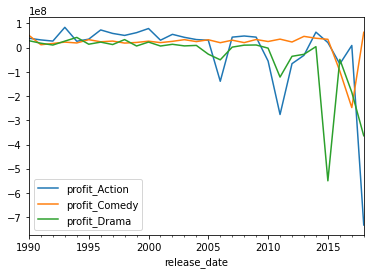

In [66]:
ts_df = ts_df.loc['1990-01-01':'2019-01-01']
ts_df.plot()